In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 7.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=d9bbf795cde63d1041bc27ebe2ffe5a0c7ea2698c4862eb2fc9c1c0c04e5737c
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [3]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!mkdir '/root/.kaggle/'
!cp '/content/drive/MyDrive/kaggle.json' '/root/.kaggle/kaggle.json'
!chmod 600 '/root/.kaggle/kaggle.json'

In [5]:
!kaggle datasets download --force -d debashishsau/aslamerican-sign-language-aplhabet-dataset

100% 4.19G/4.20G [00:33<00:00, 157MB/s]
100% 4.20G/4.20G [00:33<00:00, 136MB/s]


In [6]:
!unzip /content/aslamerican-sign-language-aplhabet-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2863).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2864).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2865).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2866).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2867).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2868).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2869).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (287).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2870).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2871).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2872).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2873).jpg  
  inflating: A

In [7]:
# split data from train folder to train/test/validation(train dataset has a lot of data and test data is just 29 images)
import splitfolders

splitfolders.ratio('/content/ASL_Alphabet_Dataset/asl_alphabet_train', output='/content/Dataset', ratio=(.7, .0, .3), group_prefix=None, move=False) # 70% train, 0% val, 30% test

Copying files: 223074 files [01:23, 2676.91 files/s]


# Preprocessing 

In [8]:
import tensorflow as tf
print(tf.__version__)

train_dir = '/content/Dataset/train'
test_dir = '/content/Dataset/test'

batch_size = 64
img_height = 100
img_width = 100

seed = 123

#img_height = 200
#img_width = 200

#img_height = 224
#img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset = 'training',
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical' # categorical because model uses a categorical_crossentropy
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset = 'validation',
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

num_of_classes = len(train_ds.class_names)
print(train_ds.class_names)

2.8.2
Found 156140 files belonging to 29 classes.
Using 124912 files for training.
Found 156140 files belonging to 29 classes.
Using 31228 files for validation.
Found 66934 files belonging to 29 classes.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


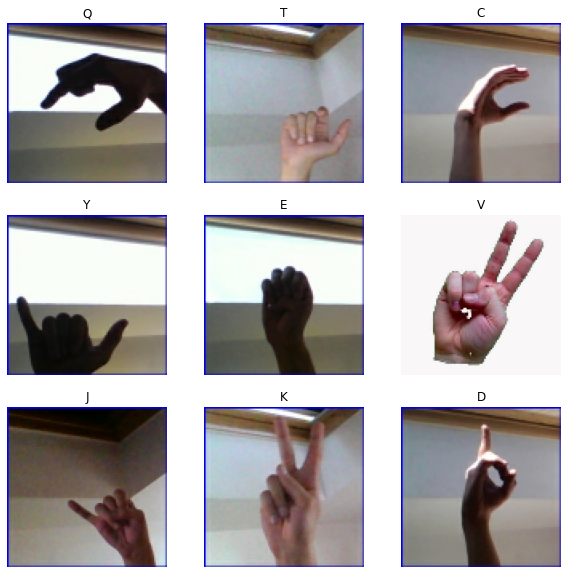

In [9]:
# display data
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(train_ds.class_names[np.argmax(labels[i])])
    plt.axis('off')

In [10]:
train_ds.element_spec

(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 29), dtype=tf.float32, name=None))

In [11]:
# augmentation layers for the training
data_augmentation = tf.keras.Sequential()
#data_augmentation.add(tf.keras.layers.RandomFlip())
data_augmentation.add(tf.keras.layers.RandomZoom((0.1,0.15), fill_mode='nearest'))
data_augmentation.add(tf.keras.layers.RandomRotation(0.05, fill_mode='nearest'))
data_augmentation.add(tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode='nearest'))

def prepare_ds(preprocessing, augmentation = None):

  if augmentation:
    def f(x, y):
      return preprocessing(augmentation(x, training=True)), y
      #return augmentation(x, training=True), y

    return f
  else:
    def f(x, y):
      return preprocessing(x), y

    return f

In [12]:
# preprocesing for ResNet50
from keras.applications.resnet import preprocess_input as resnet50_preprocessing

train_ds = (
    train_ds
    .map(prepare_ds(resnet50_preprocessing, data_augmentation), num_parallel_calls=tf.data.AUTOTUNE) # apply data_augmentation only on the train_ds
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_ds
    .map(prepare_ds(resnet50_preprocessing), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_ds
    .map(prepare_ds(resnet50_preprocessing), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

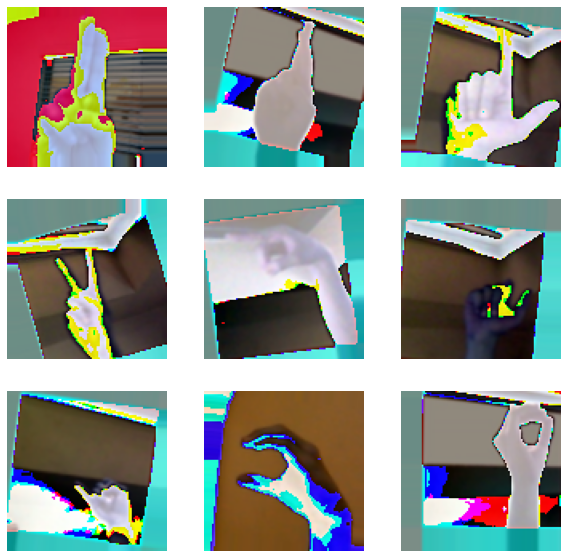

In [13]:
# display data
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    #plt.title(train_ds.class_names[np.argmax(labels[i])])
    plt.axis('off')

# ResNet50

In [14]:
# ResNet50 model
from keras.applications.resnet import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

94781440/94765736 [==============================] - 0s 0us/step


In [15]:
# hyperparameters tuning
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 28.6 MB/s 


In [16]:
import keras_tuner as kt

def model_builder(hp):

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  hp_units = hp.Int('units', min_value=128, max_value=256, step=128)

  # define top model

  top_model = tf.keras.models.Sequential()
  top_model.add(tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:]))
  top_model.add(tf.keras.layers.Dense(hp_units, activation='relu'))
  top_model.add(tf.keras.layers.Dense(hp_units, activation='relu'))
  top_model.add(tf.keras.layers.Dense(num_of_classes, activation='softmax'))

  model = tf.keras.models.Sequential() 
  model.add(base_model)
  model.add(top_model)

  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  
  return model 

In [17]:
tuner = kt.Hyperband(model_builder,
                     objective='val_categorical_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/asl_recognition',
                     project_name='ASL_recognition_resnet50', overwrite=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_ds, validation_data=val_ds, epochs=50, callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 6 Complete [00h 13m 29s]
val_categorical_accuracy: 0.4716600477695465

Best val_categorical_accuracy So Far: 0.8364288210868835
Total elapsed time: 01h 25m 58s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds, validation_data=val_ds, epochs=50) # train model with optimal parameters

val_acc_per_epoch = history.history['val_categorical_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1 # find optimal number of epochs
print('Best epoch: %d' % (best_epoch,))

hypermodel = tuner.hypermodel.build(best_hps) 

history = hypermodel.fit(train_ds, validation_data=val_ds, epochs=best_epoch)

Epoch 1/50
1952/1952 [==============================] - 401s 204ms/step - loss: 0.8685 - categorical_accuracy: 0.7255 - val_loss: 0.6516 - val_categorical_accuracy: 0.7980
Epoch 2/50
1952/1952 [==============================] - 396s 203ms/step - loss: 0.3075 - categorical_accuracy: 0.8964 - val_loss: 0.4669 - val_categorical_accuracy: 0.8572
Epoch 3/50
1952/1952 [==============================] - 395s 202ms/step - loss: 0.2125 - categorical_accuracy: 0.9271 - val_loss: 0.3888 - val_categorical_accuracy: 0.8793
Epoch 4/50
1952/1952 [==============================] - 395s 202ms/step - loss: 0.1688 - categorical_accuracy: 0.9428 - val_loss: 0.3824 - val_categorical_accuracy: 0.8821
Epoch 5/50
1952/1952 [==============================] - 389s 199ms/step - loss: 0.1404 - categorical_accuracy: 0.9520 - val_loss: 0.3755 - val_categorical_accuracy: 0.8856
Epoch 6/50
1952/1952 [==============================] - 389s 199ms/step - loss: 0.1182 - categorical_accuracy: 0.9596 - val_loss: 0.3358 - v

In [ ]:
hypermodel.save('/content/drive/MyDrive/best_resnet_model')

In [ ]:
# learning curves
plt.plot(history.history['categorical_accuracy'], label = 'categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'val_categorical_accuracy')

plt.legend()
plt.show()

In [ ]:
eval_result = hypermodel.evaluate(test_ds)

# MobileNet

In [ ]:
# load unpreprocessed data
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset = 'training',
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical' # categorical because model uses a categorical_crossentropy
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset = 'validation',
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

# preprocesing for MobileNet
from keras.applications.mobilenet import preprocess_input as mobilenet_preprocessing

train_ds = (
    train_ds
    .map(prepare_ds(mobilenet_preprocessing, data_augmentation), num_parallel_calls=tf.data.AUTOTUNE) # apply data_augmentation only on the train_ds
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_ds
    .map(prepare_ds(mobilenet_preprocessing), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_ds
    .map(prepare_ds(mobilenet_preprocessing), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
# loading new base model
from keras.applications.mobilenet import MobileNet

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

In [ ]:
import keras_tuner as kt

def model_builder(hp):

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  hp_units = hp.Int('units', min_value=128, max_value=256, step=128)

  # define top model

  top_model = tf.keras.models.Sequential()
  top_model.add(tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:]))
  top_model.add(tf.keras.layers.Dense(hp_units, activation='relu'))
  top_model.add(tf.keras.layers.Dense(hp_units, activation='relu'))
  top_model.add(tf.keras.layers.Dense(num_of_classes, activation='softmax'))

  model = tf.keras.models.Sequential() 
  model.add(base_model)
  model.add(top_model)

  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  
  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_categorical_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/asl_recognition',
                     project_name='ASL_recognition_mobilenet', overwrite=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_ds, validation_data=val_ds, epochs=50, callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds, validation_data=val_ds, epochs=50) # train model with optimal parameters

val_acc_per_epoch = history.history['val_categorical_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1 # find optimal number of epochs
print('Best epoch: %d' % (best_epoch,))

hypermodel = tuner.hypermodel.build(best_hps) 

history = model.fit(train_ds, validation_data=val_ds, epochs=best_epoch)

In [ ]:
# learning curves
plt.plot(history.history['categorical_accuracy'], label = 'categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'val_categorical_accuracy')

plt.legend()
plt.show()

In [ ]:
eval_result = hypermodel.evaluate(test_ds)

### PODSUMOWANIE